In [1]:
import multiprocessing
from functools import reduce
import operator
import random
import h5py

import numpy as np
import matplotlib.pyplot as plt
from neuron import h

%load_ext autoreload
%autoreload 2

from GrC import GrC
from Golgi import Golgi
from utils import export_data

# Random generator
local_random = np.random.default_rng(123)

np.random.seed(42)

In [2]:
# Instantiation of the cell templates

cell_dict = {}

cell_dict['golgi_cells'] = [[Golgi(i, morpho) for i in range(count)] for morpho, count in (
    (1, 5),  # 1 of morpho 1
    (2, 5),  # 1 of morpho 2
 )]

golgi_cells = cell_dict['golgi_cells']
golgi_cells = reduce(operator.concat, golgi_cells)[:2]
golgi_cells = golgi_cells[:2]

cell_dict["grc_cells"] = [[GrC(i, subtype) for i in range(count)] for subtype, count in (
    ("regular", 2), # 20%
    ("mild", 3), # 30%
    ("adapting", 4), # 40%
    ("accelerate", 1), # 10%
)]

grc_cells = cell_dict['grc_cells']
grc_cells = reduce(operator.concat, grc_cells)[:2]
random.shuffle(grc_cells)
grc_cells = grc_cells[:2]

ascending_axons = sum((grc_cell.HD_aa for grc_cell in grc_cells), [])
parallel_fibers = sum((grc_cell.HD_pf for grc_cell in grc_cells), [])


5394 lines read

5394 lines read

5394 lines read

5456 lines read

morphology/pair-140514-C2-1_split_2.asc problems


Main branch starting at line 58 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma

Main branch starting at line 2375 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma

5456 lines read

morphology/pair-140514-C2-1_split_2.asc problems


Main branch starting at line 58 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma

Main branch starting at line 2375 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma

103 lines read

103 lines read

103 lines read

103 lines read

103 lines read

103 lines read

103 lines read

103 lines read

103 lines read

103 lines read


In [3]:
# Fixed time step only
time_step = h.CVode()
time_step.active(0)  # 0 fixed step, 1 variable time step

# Activate the multisplit to use half of cores available (with a max of 8)
cpu = multiprocessing.cpu_count() // 2
h.load_file("parcom.hoc")
p = h.ParallelComputeTool()
p.change_nthread(min(8, cpu), 1)
p.multisplit(1)

# simulation parameters
 
h.dt = 0.025    # change in time between steps (ms)
h.celsius = 32  # temperature of the neurons (*C)
h.v_init = -65  # initial membrane potential (mV)
h.tstop = 1000 # duration of simulation (ms)

# create hoc vectors

t = h.Vector()
t.record(h._ref_t)

# Impedance class for input resistance 
input_resis = h.Impedance()

Vector[60806]

In [ ]:
spike_times = [200, 300, 400, 500]

stims_array = []
stim_rec_array = []
vs_array = []

syn_i_array = []
input_resis_array = []

golgi_ncs_array = []
grc_ncs_array = []

golgi_spike_t_array = []
grc_spike_t_array = []

max_golgi_v_array = []
min_golgi_v_array = []
max_grc_v_array = []
min_grc_v_array = []

stim_data_pf = {'delay': 200, 'duration': 1000, 'amp': 20, 'spike_times': spike_times}
stim_data_mf = {'delay': 200, 'duration': 1000, 'amp': 20, 'spike_times': spike_times}
stim_data_aa = {'delay': 200, 'duration': 1000, 'amp': 20, 'spike_times': spike_times}

In [4]:
def create_syn_stim_bursts(cell, synapses, synapse_data_mf, spike_times):

    """
    Generates single pulse current to soma of cell. 

    delay: time after amp is injected
    dur: duration of amp injection
    amp: amount of amp injected
    """

    stim = h.IClamp(cell.soma[0](0.5))
    stim.delay = synapse_data_mf['delay']
    stim.dur = synapse_data_mf['duration']
    stim.amp = synapse_data_mf['amp']
    stims_array.append(stim)

    stim_i_rec = h.Vector()
    stim_rec_array.append(stim_i_rec.record(stim._ref_i))

    if type(synapses) == type(grc_cells):
        grc_ncs_array.extend(h.NetCon(stim, syn.input, 0, 0.1, 1) for syn in synapses)
        
    else:
        golgi_ncs_array.extend(h.NetCon(stim, syn.input, 0, 0.1, 1) for syn in synapses)   

    vs = h.Vector() 
    vs_array.append(vs.play(stim.amp, spike_times))  

In [5]:
for j, grc_cell in enumerate(grc_cells):
    
    # number of AMPA syn, NMDA syn, GABA syn, dend number from indices
    grc_cell.createsyn(4, 4, 3, [0, 1, 2, 3]) # 4 dendritic comparts (0-3)
    
    # mossy fiber connection
    create_syn_stim_bursts(grc_cell, grc_cell.MF_GrC_AMPA + grc_cell.MF_GrC_NMDA_B, stim_data_mf, spike_times)

    # golgi cell connection 
    for i, golgi_cell in enumerate(golgi_cells):
        grc = grc_cell.dend[:]
        sections = [grc[random.randrange(len(grc))] for _ in grc] 
        grc_ncs_array.extend(h.NetCon(sec(0.5)._ref_v, syn.input, 0, 0.1, 1, sec=sec) 
                    for syn, sec in zip(grc_cell.GoC_GrC_GABA, sections))

    input_resis_vec = h.Vector()
    # input_resis.loc(grc_cell.soma[0](0.5)) # location of where input resis will be measured
    # input_resis.input(grc_cell.soma[0](0.5)) # calculates value of input resistance (Megaohms)
    # input_resis_array.append(input_resis_vec.record(input_resis.transfer)) # store values of input_resis in array

    grc_spike_t_array.append(grc_cell.nc_spike) # store number of times fired in array
        
for j, golgi_cell in enumerate(golgi_cells):

    # number of AMPA syn, NMDA syn, dend number from 0 to 3

    # Create the synapses (max used in the paper: 89, 20, 20)
    # Not included: inhibitory synapses (up to 20 in the paper)

    # 1 Parallel Fiber reaches 8 Golgi cells, each one synapses ~3 times onto a Golgi cell, 400 Parallel Fibers connect to a single Golgi cell

    # 1 Ascending Axon reaches 23 Golgi cells, each one synapses ~1 times onto a Golgi cell. About 400 ascending axons synapse onto a golgi cell

    # 1 golgi cell reaches 40 mossy fibers, each one synapses ~1 time onto a golgi cell, one golgi cell recieves input 
    # from 40 different mossy fibers

    golgi_cell.createsyn(mf_n=40, # 40
                         pf_n=len(grc_cells)*3,
                         aa_n=len(ascending_axons)//4) 
    
    # No Mossy Fiber Connection for golgi

    # Parallel Fiber Connections
    for i, grc_cell in enumerate(grc_cells):
        pf_i = random.randrange(0, len(grc_cell.HD_pf))
        pf = grc_cell.HD_pf[pf_i]
        sections = [pf[random.randrange(len(pf))] for _ in golgi_cell.L_PF] 
        golgi_ncs_array.extend(h.NetCon(sec(0.5)._ref_v, syn.input, 0, 0.1, 1, sec=sec)
                   for syn, sec in zip(golgi_cell.L_PF, sections))
        golgi_ncs_array.extend(h.NetCon(sec(0.5)._ref_v, syn.input, 0, 0.1, 1, sec=sec)
                   for syn, sec in zip(golgi_cell.L_PF_NMDA, sections))

    # Ascending Axons Connections
    for i, grc_cell in enumerate(grc_cells):
        n = len(grc_cell.HD_aa)
        locations = np.random.normal(n/2, 2, len(golgi_cell.L_AA)).round().astype(int).clip(0, n-1)
        sections = [grc_cell.HD_aa[loc] for loc in locations]
        golgi_ncs_array.extend(h.NetCon(sec(0.5)._ref_v, syn.input, 0, 0.1, 1, sec=sec)
                   for syn, sec in zip(golgi_cell.L_AA, sections))
        golgi_ncs_array.extend(h.NetCon(sec(0.5)._ref_v, syn.input, 0, 0.1, 1, sec=sec)
                   for syn, sec in zip(golgi_cell.L_AA_NMDA_B, sections))

    input_resis_vec = h.Vector()
    # input_resis.loc(golgi_cell.soma[0](0.5)) # location of where input resis will be measured
    # input_resis.transfer(golgi_cell.soma[0](0.5)) # calculates value of input resistance (Megaohms)
    # input_resis_array.append(input_resis_vec.record(input_resis.transfer)) # store values of input_resis in array

    golgi_spike_t_array.append(golgi_cell.nc_spike)

In [6]:
# run simulation

h.run()

exp(15751.7) out of range, returning exp(700)
exp(15751.7) out of range, returning exp(700)


0.0

exp(3975.42) out of range, returning exp(700)
exp(3975.42) out of range, returning exp(700)
No more errno warnings during this execution


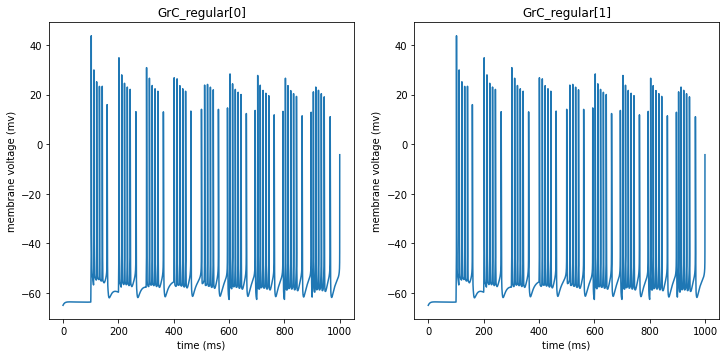

In [7]:
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(1, 2, figsize = (10, 8))

for j, grc_cell in enumerate(grc_cells):
    plt.subplot(len(grc_cells), 2, j + 1)
    plt.plot(t, grc_cell.vm, label=str(grc_cell))
    plt.title(f"{grc_cell}")
    plt.xlabel("time (ms)")
    plt.ylabel("membrane voltage (mv)")

plt.tight_layout()
plt.show()
plt.savefig('sm_network_grc_cells.svg', dpi = 300, facecolor='white', transparent=True)

nan
135.52187766085623


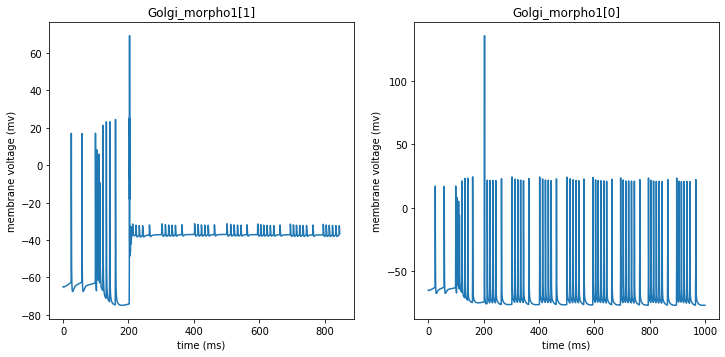

In [8]:
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(1, 2, figsize = (10, 8))
for j, golgi_cell in enumerate(golgi_cells):
    plt.subplot(len(golgi_cells), 2, j + 1)
    plt.plot(t, golgi_cell.vm, label=str(golgi_cell))
    plt.title(f"{golgi_cell}")
    plt.xlabel("time (ms)")
    plt.ylabel("membrane voltage (mv)")

plt.tight_layout()
plt.show()
plt.savefig('sm_network_golgi_cells.svg', dpi = 300, facecolor='white', transparent=True)

In [ ]:
max_grc_v_array.append(np.max(np.array(grc_cell.vm)))
min_grc_v_array.append(np.min(np.array(grc_cell.vm)))
max_golgi_v_array.append(np.max(np.array(golgi_cell.vm)))
min_golgi_v_array.append(np.min(np.array(golgi_cell.vm)))

In [9]:
sim_dict = {'data': {'time_array': t,
                     'stim_rec_array': stim_rec_array,
                    #  'syn_i_array': syn_i_array,
                    #  'stims_array': stims_array,
                     'input_resis_array': input_resis_array,
                     'golgi_spike_t_array': golgi_spike_t_array,
                     'grc_spike_t_array': grc_spike_t_array,      
                     'golgi_ncs_array': golgi_ncs_array,
                     'grc_ncs_array': grc_ncs_array,
                     'max_golgi_v_array': max_golgi_v_array,
                     'min_golgi_v_array': min_golgi_v_array,
                     'max_grc_v_array': max_golgi_v_array,
                     'min_golgi_v_array': min_golgi_v_array},
            'metadata': {'cell_dict': cell_dict,
                         'grc_cells': grc_cells, 
                         'golgi_cells': golgi_cells, 
                         'ascending_axons': ascending_axons,
                         'parallel_fibers': parallel_fibers,
                         'spike_times': spike_times,
                         'synapse_data_pf': stim_data_pf,
                         'synapse_data_mf': stim_data_mf,
                         'synapse_data_aa': stim_data_aa},
            'parameters': {'time_steps': h.dt,
                           'temp': h.celsius,
                           'v_init': h.v_init,
                           'duration': h.tstop}}

NameError: name 'sorted_weight_history' is not defined

In [ ]:
file_path = 'data/sim_history.hdf5'
model_name = 'sm_network'
export_data(sim_dict, model_name, file_path)